# Sparse Autoencoder

Implement an autoencoder with the sparsity constraint. You can build on the MLP implementation from EE5600. Choose your network size appropriately (meaning a size that you can train and test on your computer without running into memory issues).

In [107]:
import numpy as np
import tensorflow as tf

In [108]:
# Get the MNIST data from keras, downsample and save to csv file
# No need to run this chunk of code again as csv files with 14x14 images are saved 
# Each image is saved as 196 dim vector with label as it's label
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = np.reshape(x_train, newshape=(*x_train.shape, 1))
x_train = tf.image.resize_images(images=x_train, size=(14,14))
x = tf.Session().run(x_train)
x_train = np.asarray(x, dtype=np.uint8).reshape(x_train.shape[0], 196) / 255.
# pd.DataFrame(x_train).to_csv('train.csv', sep=',', index=True, header=False)

x_test = np.reshape(x_test, newshape=(*x_test.shape, 1))
x_test = tf.image.resize_images(images=x_test, size=(14,14))
x = tf.Session().run(x_test)
x_test = np.asarray(x, dtype=np.uint8).reshape(x_test.shape[0], 196) / 255.
# pd.DataFrame(x_test).to_csv('train.csv', sep=',', index=True, header=False)

In [109]:
import matplotlib.pyplot as plt
def show_digit(x): # x - 196 dim vector
    x = np.reshape(x, (14,14))
    plt.imshow(x, cmap='gray')
    plt.show()

In [118]:
class NN(object):
    def __init__(self, input_dim, hidden_dim, learn_rate, sparsity, regularization):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim
        self.learn_rate = learn_rate
        self.s = sparsity
        self.Lambda = regularization
        # intialize weights
        self.A = np.random.normal(0,  1, (self.hidden_dim, self.input_dim))
        self.B = np.random.normal(0,  1, (self.output_dim, self.hidden_dim))
        self.a0 = np.random.normal(0, 1, self.hidden_dim)
        self.b0 = np.random.normal(0, 1, self.output_dim)

    def sigmoid(self, t):
        return 1/(1  + np.exp(-t))

    def dsigmoid(self, t):
        return self.sigmoid(t)*(1 - self.sigmoid(t))

    def hidden_layer(self, x):
        # A.shape:mxd; x.shape;(d,); so z.shape=(m,)
        z = self.sigmoid(np.dot(self.A, x) + self.a0) 
        return z

    def forward_pass(self, x):
        # B.shape:kxm; z.shape;m; so y_hat.shape=k
        y_hat = self.sigmoid(np.dot(self.B, self.hidden_layer(x)) + self.b0)
        return y_hat
    
    def loss(self, y_train, y_hat):
        return np.sum((y_train - y_hat)**2)
    
    def back_propogate(self, X, Y, Y_hat):
        self.N = len(X)
        dSSE_A, dSSE_a0 = np.zeros_like(self.A), np.zeros_like(self.a0)
        dSSE_B, dSSE_b0 = np.zeros_like(self.B), np.zeros_like(self.b0)
        A_new = np.zeros_like(self.A)
        Z = self.sigmoid(self.a0 + np.dot(X, self.A.T))  # Z.shape = (N,m)
        dZ = self.dsigmoid(self.a0 + np.dot(X, self.A.T)) # dZ shape = (N,m)
        print('Z.shape = ', Z.shape)
        # y_delta.shape (N,k)
        y_delta = -2*(Y-Y_hat) * self.dsigmoid(self.b0 + np.dot(Z, self.B.T))
        print('Y_delta shape', y_delta.shape)
        # z_delta.shape (N,m)
        z_delta = np.transpose(-dZ.T * np.sum(y_delta, axis=1))
        print('Z delta Shape', z_delta.shape)
        zm = np.mean(Z, axis=0)
        print('Zm', zm, zm.shape)
        # dKL shape = (N,m) 
        dKL = (-self.s/zm) + ((1-self.s)/(1-zm)) # shape: (m,)
        print('fuck you', dKL)
        dKL = self.Lambda * dKL * dZ  # shape: (N,m)
        print('KL ', dKL.shape)
        dSSE_A = np.matmul((z_delta + dKL).T, X)
        print('dSSE_A', dSSE_A.shape)
        dSSE_a0 = np.sum((z_delta+dKL), axis=0)
        print('dSSE_a0', dSSE_a0.shape)
        dSSE_B = np.matmul(y_delta.T, Z)
        dSSE_b0 = np.sum(y_delta, axis=0)
        # update weights 
        A_new = self.A - (self.learn_rate*dSSE_A)
        a0_new = self.a0 - (self.learn_rate*dSSE_a0)
        B_new = self.B - (self.learn_rate*dSSE_B)
        b0_new = self.b0 - (self.learn_rate*dSSE_b0)
        return (A_new, a0_new, B_new, b0_new)
    
    def train(self, x_train, y_train, epochs, shuffle=True): 
        if shuffle:
            indices = np.arange(N)
            np.random.shuffle(indices)
            x_train, y_train = x_train[indices], y_train[indices]

        epoch = 1
        while(epoch <= epochs):
            Y_hat = np.array([self.forward_pass(x) for x in x_train])
            (self.A, self.a0, self.B, self.b0) = self.back_propogate(X=x_train, Y=y_train, Y_hat=Y_hat)
            print('Epoch: ', epoch, 'Loss: ', self.loss(y_train, Y_hat))
            show_digit(x_train[0])
            show_digit(Y_hat[0])
            epoch += 1
        print('Done Training')


In [119]:
SparseAE = NN(input_dim=196, hidden_dim=256, learn_rate=0.1, sparsity=0.1, regularization=0.1)

Z.shape =  (60000, 256)
Y_delta shape (60000, 196)
Z delta Shape (60000, 256)
Zm [0.47330423 0.55700719 0.92198214 0.66331185 0.33283239 0.20543146
 0.75509947 0.14235834 0.15505462 0.18796779 0.8405446  0.44035435
 0.39345311 0.65253873 0.57035744 0.77876039 0.79165007 0.53993616
 0.3605659  0.53178588 0.37642466 0.47439363 0.53213237 0.28118614
 0.3874165  0.85618746 0.5645716  0.14732444 0.53705925 0.4462694
 0.2207599  0.18849168 0.29739397 0.69901326 0.35208899 0.64961172
 0.88195597 0.13556137 0.55844393 0.10350418 0.2889576  0.3769927
 0.37234046 0.94038518 0.11763211 0.07384792 0.64473391 0.71844255
 0.54917411 0.21989831 0.33031126 0.71483669 0.20333085 0.60782717
 0.6171063  0.31036539 0.31709279 0.09145457 0.22619257 0.81000278
 0.48161382 0.3848427  0.26191164 0.51862425 0.31486435 0.73403726
 0.52013626 0.35312161 0.57208884 0.60778089 0.53965323 0.7199912
 0.05202799 0.33530177 0.76225965 0.21787273 0.80085168 0.49075579
 0.63442951 0.7408646  0.51839649 0.42724923 0.3502

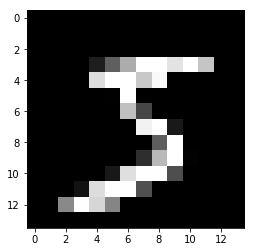

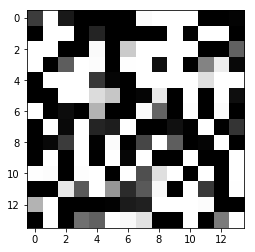

/home/aravind/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Z.shape =  (60000, 256)
Y_delta shape (60000, 196)
Z delta Shape (60000, 256)
Zm [1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e

/home/aravind/.local/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/home/aravind/.local/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply


dSSE_A (256, 196)
dSSE_a0 (256,)
Epoch:  2 Loss:  874504865674.5115


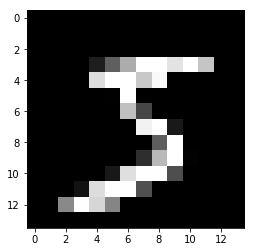

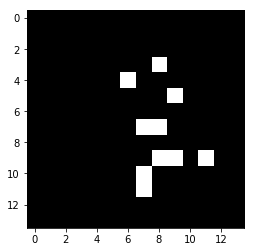

Z.shape =  (60000, 256)
Y_delta shape (60000, 196)
Z delta Shape (60000, 256)
Zm [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan    

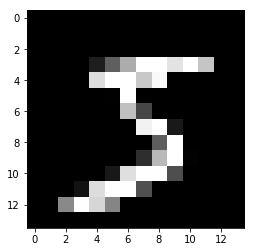

/home/aravind/.local/lib/python3.5/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/aravind/.local/lib/python3.5/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/aravind/.local/lib/python3.5/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/aravind/.local/lib/python3.5/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/aravind/.local/lib/python3.5/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/aravind/.local/lib/python3.5/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


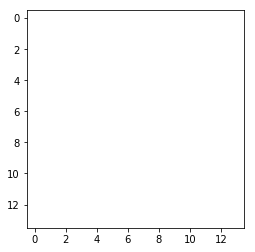

Z.shape =  (60000, 256)
Y_delta shape (60000, 196)
Z delta Shape (60000, 256)
Zm [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan na

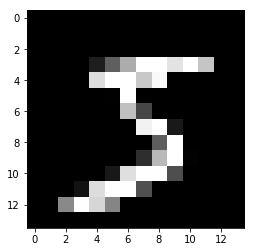

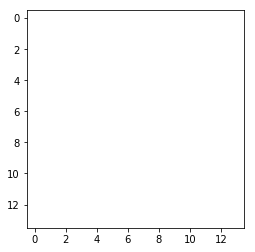

Z.shape =  (60000, 256)
Y_delta shape (60000, 196)
Z delta Shape (60000, 256)
Zm [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan na

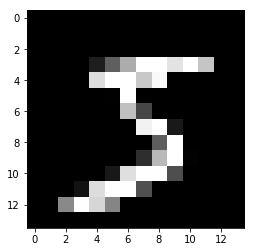

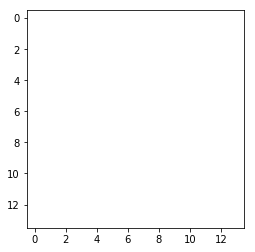

KeyboardInterrupt: 

In [117]:
SparseAE.train(x_train=x_train, y_train=x_train, epochs=10, shuffle=False)